In [1]:
%matplotlib inline

import dlc_practical_prologue as prologue
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import random
from models import FNN, FNN_WS, FNN_WS_AUX, FNN_AUX, CNN, CNN_WS_AUX, CNN_WS, CNN_AUX
import timeit

### _I - Setting up_

##### Loading data

In [48]:
def load():

    # Load the data
    size = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(size)

    #normalization
    #check https://stats.stackexchange.com/questions/174823/
    mu, std = train_input.mean(), train_input.std()
    train_input, test_input = train_input.sub(mu).div(std), test_input.sub(mu).div(std)

    #split the images
    train_input1, train_input2 = train_input[:, 0, :, :], train_input[:, 1, :, :] 
    test_input1, test_input2 = test_input[:, 0, :, :], test_input[:, 1, :, :] 

    #split the number pairs
    train_classes1, train_classes2 = train_classes[:, 0], train_classes[:, 1]
    test_classes1, test_classes2 = test_classes[:, 0], test_classes[:, 1]
    
    inputs = [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target]
    
    return inputs


In [3]:
 [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target] = load()

##### Batch generator

In [38]:
def data_generator(input1, input2, digits1, digits2, targets, batch_size):
    data_len = input1.size(0)
    i = 0
    while i < data_len:
        j = i + batch_size if i +batch_size < data_len else data_len
        yield input1[i:j], input2[i:j], \
              digits1[i:j],digits2[i:j],\
              targets[i:j]
        i = j  

### _II - Defining the models_

In [5]:
"""
:param model_constructor: constructor for the model
:param optimizer_name: 'sgd' or 'adam'
:param lr: learning rate
:param batch_size: batch_size.
:return: an encapsulated model ready for the training
"""
def model_selector(model_constructor, optimizer_name, lr, batch_size, weight_decay=0, nb_epochs=25):
    
    model = dict()
    model['model'] = model_constructor()
    model['criterion'] = nn.CrossEntropyLoss()
    model['nb_epochs'] = nb_epochs
    model['batch_size'] = batch_size
    if(optimizer_name == 'sgd'):
        model['optimizer'] = torch.optim.SGD(model['model'].parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'adam':
        model['optimizer'] =  torch.optim.Adam(model['model'].parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
    return model

In [6]:
def initialize_models():
    model_FNN = model_selector(FNN, 'adam', 0.014, 64, weight_decay = 0.001, nb_epochs = 50)
    model_FNN_WS = model_selector(FNN_WS, 'adam', 0.013 , 64, weight_decay = 0.01, nb_epochs=50)
    model_FNN_WS_AUX = model_selector(FNN_WS_AUX, 'adam', 0.014, 64, weight_decay = 0,nb_epochs=50 )
    model_FNN_AUX = model_selector(FNN_AUX, 'adam', 0.012 ,64, weight_decay = 0, nb_epochs = 50)

    model_CNN = model_selector(CNN, 'adam', 0.01, 64, weight_decay = 0.001, nb_epochs = 50)
    model_CNN_WS_AUX = model_selector(CNN_WS_AUX, 'adam', 0.014 , 64, weight_decay = 0.001, nb_epochs = 50)
    model_CNN_WS = model_selector(CNN_WS, 'adam', 0.014 , 64, weight_decay = 0.001, nb_epochs = 50)
    model_CNN_AUX = model_selector(CNN_AUX, 'adam', 0.013, 64, weight_decay = 0, nb_epochs = 50)
    
    models = [model_FNN, model_FNN_WS, model_FNN_AUX, model_FNN_WS_AUX, model_CNN, model_CNN_WS, model_CNN_AUX, model_CNN_WS_AUX]
    
    return models

### _III - Training the models_

##### Training and saving the histories

In [7]:
"""
:param model: a dict encapsulating the model and its properties
:param input1_tr: lhs of image pairs from training set
:param input2_tr: rhs of image pairs from training set
:param input1_te: lhs of image pairs from test set
:param input2_te: rhs of image pairs from test set
:param digits1_tr: classes of input1 from training set
:param digits2_tr: classes of input2 from training set
:param digits1_te: classes of input1 from test set
:param digits2_te: classes of input2 from test set
:param targets_tr: final boolean value indicating whether lhs <= rhs from training set
:param targets_te: final boolean value indicating whether lhs <= rhs from test set
:return: a dict encapsulating the model history
"""
def train(model, input1_tr, input2_tr, digits1_tr, digits2_tr, targets_tr, \
                 input1_te =None, input2_te =None, digits1_te=None, digits2_te=None, targets_te=None):
    
    epochs = model['nb_epochs']
    batch_size = model['batch_size']
    criterion = model['criterion']
    optimizer = model['optimizer']
    mdl = model['model']
      
    #  a dict to return whatever value we want to return
    #  e.g. loss at each epoch (useful for plotting)
    model_history = dict()
    
    
    train_loss_history = [] #a list to keep track of the losses at each epoch
    test_loss_history = []
    test_acc_history = []
    
    for e in range(epochs):
        
        epoch_train_loss = 0
        generator = data_generator(input1_tr, input2_tr, digits1_tr, digits2_tr, targets_tr, batch_size)
        for input1, input2, digits1, digits2, targets in generator:
            d1, d2, pred = mdl(input1, input2)   # run through the network
            pred_loss =  criterion(pred.view(-1, 2), targets) # loss due to boolean value
     
            if d1 is not None:
                pred_loss += criterion(d1.view(-1, 10), digits1)
                pred_loss += criterion(d2.view(-1, 10), digits2)
                pred_loss /= 3
                
            loss = pred_loss.item() #magnitude of the loss
            epoch_train_loss += loss
            mdl.zero_grad()         #reset the gradients for this epoch
            pred_loss.backward()    #calculate the gradients
            optimizer.step()        #update the weights
             
        train_loss_history.append(epoch_train_loss) #record the train loss 
        
        
        if input1_te is not None:
            epoch_test_loss = 0
            test_generator = data_generator(input1_te, input2_te, digits1_te, digits2_te, targets_te, batch_size)
            with torch.no_grad():
                for input1, input2, digits1, digits2, targets in test_generator:
                    d1, d2, pred = mdl(input1, input2)
                    pred_loss =  criterion(pred.view(-1, 2), targets)

                    if d1 is not None:
                        pred_loss += criterion(d1.view(-1, 10), digits1)
                        pred_loss += criterion(d2.view(-1, 10), digits2)
                        pred_loss /= 3

                    loss = pred_loss.item()
                    epoch_test_loss += loss

            test_loss_history.append(epoch_test_loss) #record the test loss
            
            acc_target, _, _= compute_nb_errors(mdl, input1_te, input2_te, digits1_te, digits2_te, targets_te)
            test_acc_history.append(acc_target)

        
        
        
    model_history['train_loss_history'] = train_loss_history
    model_history['test_loss_history'] = test_loss_history
    model_history['test_acc_history'] = test_acc_history
    return model_history

##### Computes the accuracy of the given model on the given data

In [8]:
"""
:param model: a dict encapsulating the model and its properties
:param input1: lhs of image pairs
:param input2: rhs of image pairs
:param digits1: classes of input1 
:param digits2: classes of input2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a triplet indicating the accuracies ordered as (boolean,lhs,rhs)
"""
def compute_nb_errors(model, input1, input2, digits1, digits2, targets):
    n_samples = input1.shape[0]
    with torch.no_grad():
        d1,d2,pred = model(input1, input2)           # predict the digits + boolean
        _, indices = torch.max(pred.view(-1,2), 1) # torch.max returns the max value from the distribution and its corresponding index
        acc_target = (sum(indices == targets) / float(n_samples) * 100).item()  #calculate accuracy

        acc_d1, acc_d2 = 0, 0
        if d1 is not None: #the model returns digits if it makes use of aux loss. in this case we can report the accuracy of predicting the digits.
            _, indices1 = torch.max(d1.view(-1,10), 1)
            _, indices2 = torch.max(d2.view(-1,10), 1)
            acc_d1 += (sum(indices1 == digits1) / float(n_samples) * 100).item()
            acc_d2 += (sum(indices2 == digits2) / float(n_samples) * 100).item()


        return (acc_target, acc_d1, acc_d2)

  

##### _Cross-validation_

In [9]:
"""
:param input1: lhs of image pairs
:param input2: rhs of image pairs
:param digits1: classes of input1 
:param digits2: classes of input2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a triplet indicating the accuracies ordered as (boolean,lhs,rhs)
"""
def cross_val_score(input1, input2, digits1, digits2, targets, model_constructor, optimizer_name, lr, batch_size, weight_decay,nb_epoch, k_folds=3):
    len_train = input1.shape[0]
    indices = list(range(len_train))
    random.seed(8)
    random.shuffle(indices)
    acc_target, acc_d1, acc_d2  = 0,0,0
    for k in range(k_folds):
        model = model_selector(model_constructor, optimizer_name, lr, batch_size, weight_decay, nb_epoch)  # init the same model
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        #train the model with k-1 training fold
        history = train(model, input1[train_indices], input2[train_indices], digits1[train_indices], digits2[train_indices], targets[train_indices])
        
        #compute the accuracy on 1 validation fold
        accs = compute_nb_errors(model['model'], input1[val_indices], input2[val_indices], digits1[val_indices], digits2[val_indices], targets[val_indices])
        
        acc_target += accs[0]
        acc_d1 += accs[1]
        acc_d2 += accs[2]
        #print('fold=', k, ' loss = ', history['loss_history'][-1])
    return (acc_target / k_folds, acc_d1 /k_folds, acc_d2 /k_folds)


### _IV - Hyper-parameter tuning_

##### Gird-search 

In [10]:
def grid_search():
    models = [FNN, FNN_WS, FNN_WS_AUX, FNN_AUX, CNN, CNN_WS_AUX, CNN_WS, CNN_AUX]
    epochs = [50]
    batch_sizes = [64]
    weight_decays = [0, 0.1, 0.01, 0.001]
    lrs = [0.001 * x for x in range(1, 15)]
    opts = ['adam']

    for m in models:
        best_batch, best_lr, best_opt, best_wd, best_epoch, best_acc = None, None, None, None,None,None
        for b in batch_sizes:
            for lr in lrs:
                for opt in opts:
                    for wd in weight_decays:
                        for e in epochs:
                            start = timeit.default_timer()
                            acc_t, acc_d1, acc_d2 = cross_val_score(train_input1, train_input2, train_classes1, train_classes2,  train_target, m, opt,lr,b,wd, e, k_folds=3)
                            end = timeit.default_timer()
                            print(m, b, e, wd, round(lr, 3), opt, '/// accuracies: ', acc_t, acc_d1, acc_d2, '/// time: ', round(end - start, 2))
                            if best_acc is None or acc_t > best_acc:
                                best_epoch, best_wd, best_batch, best_lr, best_opt, best_acc = e, wd, b, lr, opt, acc_t
        print('for model ', m, 'best accuracy is ', best_acc, 'at ', 'lr=', best_lr, 'b=', best_batch, 'opt=', best_opt, 'wd=', best_wd, 'epoch=', best_epoch)

In [25]:
grid_search()

<class 'models.FNN'> 64 50 0 0.001 adam /// accuracies:  75.59745025634766 0.0 0.0 /// time:  11.64
<class 'models.FNN'> 64 50 0.1 0.001 adam /// accuracies:  74.19724782307942 0.0 0.0 /// time:  10.66
<class 'models.FNN'> 64 50 0.01 0.001 adam /// accuracies:  77.19815572102864 0.0 0.0 /// time:  10.75
<class 'models.FNN'> 64 50 0.001 0.001 adam /// accuracies:  76.49925231933594 0.0 0.0 /// time:  10.85
<class 'models.FNN'> 64 50 0 0.002 adam /// accuracies:  76.99615732828777 0.0 0.0 /// time:  11.15
<class 'models.FNN'> 64 50 0.1 0.002 adam /// accuracies:  76.49655659993489 0.0 0.0 /// time:  11.53
<class 'models.FNN'> 64 50 0.01 0.002 adam /// accuracies:  75.49735260009766 0.0 0.0 /// time:  11.7
<class 'models.FNN'> 64 50 0.001 0.002 adam /// accuracies:  77.19666035970052 0.0 0.0 /// time:  13.02
<class 'models.FNN'> 64 50 0 0.003 adam /// accuracies:  78.10055541992188 0.0 0.0 /// time:  11.46
<class 'models.FNN'> 64 50 0.1 0.003 adam /// accuracies:  76.79595692952473 0.0 0.

<class 'models.FNN_WS'> 64 50 0.001 0.006 adam /// accuracies:  75.79705301920573 0.0 0.0 /// time:  10.25
<class 'models.FNN_WS'> 64 50 0 0.007 adam /// accuracies:  74.19934844970703 0.0 0.0 /// time:  10.76
<class 'models.FNN_WS'> 64 50 0.1 0.007 adam /// accuracies:  55.49621454874674 0.0 0.0 /// time:  10.45
<class 'models.FNN_WS'> 64 50 0.01 0.007 adam /// accuracies:  75.59865315755208 0.0 0.0 /// time:  10.23
<class 'models.FNN_WS'> 64 50 0.001 0.007 adam /// accuracies:  74.80234781901042 0.0 0.0 /// time:  10.34
<class 'models.FNN_WS'> 64 50 0 0.008 adam /// accuracies:  76.99975331624348 0.0 0.0 /// time:  10.95
<class 'models.FNN_WS'> 64 50 0.1 0.008 adam /// accuracies:  55.49621454874674 0.0 0.0 /// time:  11.13
<class 'models.FNN_WS'> 64 50 0.01 0.008 adam /// accuracies:  74.49725087483723 0.0 0.0 /// time:  11.58
<class 'models.FNN_WS'> 64 50 0.001 0.008 adam /// accuracies:  76.49925231933594 0.0 0.0 /// time:  11.27
<class 'models.FNN_WS'> 64 50 0 0.009 adam /// accu

<class 'models.FNN_WS_AUX'> 64 50 0.01 0.009 adam /// accuracies:  87.79648081461589 89.79907989501953 89.00127410888672 /// time:  13.24
<class 'models.FNN_WS_AUX'> 64 50 0.001 0.009 adam /// accuracies:  91.69798533121745 91.19988250732422 90.60137939453125 /// time:  11.41
<class 'models.FNN_WS_AUX'> 64 50 0 0.01 adam /// accuracies:  93.69848887125652 93.40058898925781 93.20098368326823 /// time:  11.93
<class 'models.FNN_WS_AUX'> 64 50 0.1 0.01 adam /// accuracies:  55.49621454874674 69.69454701741536 69.4982426961263 /// time:  11.76
<class 'models.FNN_WS_AUX'> 64 50 0.01 0.01 adam /// accuracies:  87.69697825113933 88.70097351074219 88.7009760538737 /// time:  11.94
<class 'models.FNN_WS_AUX'> 64 50 0.001 0.01 adam /// accuracies:  92.29828643798828 92.60038503011067 89.60007985432942 /// time:  11.3
<class 'models.FNN_WS_AUX'> 64 50 0 0.011 adam /// accuracies:  93.49858856201172 93.99818674723308 91.70068105061848 /// time:  11.5
<class 'models.FNN_WS_AUX'> 64 50 0.1 0.011 ada

<class 'models.FNN_AUX'> 64 50 0.01 0.01 adam /// accuracies:  82.89546966552734 86.1001714070638 84.30136617024739 /// time:  14.2
<class 'models.FNN_AUX'> 64 50 0.001 0.01 adam /// accuracies:  89.79638671875 89.50118001302083 87.40057627360027 /// time:  13.83
<class 'models.FNN_AUX'> 64 50 0 0.011 adam /// accuracies:  91.49778747558594 89.89918009440105 88.60177612304688 /// time:  14.43
<class 'models.FNN_AUX'> 64 50 0.1 0.011 adam /// accuracies:  55.49621454874674 11.999724388122559 11.698524792989096 /// time:  14.28
<class 'models.FNN_AUX'> 64 50 0.01 0.011 adam /// accuracies:  82.69467163085938 86.39987436930339 84.40086873372395 /// time:  14.26
<class 'models.FNN_AUX'> 64 50 0.001 0.011 adam /// accuracies:  89.29917907714844 88.1998774210612 86.50147501627605 /// time:  14.42
<class 'models.FNN_AUX'> 64 50 0 0.012 adam /// accuracies:  92.69868723551433 91.0997823079427 89.49937947591145 /// time:  15.12
<class 'models.FNN_AUX'> 64 50 0.1 0.012 adam /// accuracies:  55.4

<class 'models.CNN_WS_AUX'> 64 50 0 0.001 adam /// accuracies:  90.39908091227214 94.00118764241536 93.50038655598958 /// time:  46.21
<class 'models.CNN_WS_AUX'> 64 50 0.1 0.001 adam /// accuracies:  86.49937438964844 95.19968922932942 95.40049235026042 /// time:  46.61
<class 'models.CNN_WS_AUX'> 64 50 0.01 0.001 adam /// accuracies:  90.10207875569661 94.10038757324219 93.39878590901692 /// time:  46.39
<class 'models.CNN_WS_AUX'> 64 50 0.001 0.001 adam /// accuracies:  89.498779296875 93.79918924967448 93.30018615722656 /// time:  47.01
<class 'models.CNN_WS_AUX'> 64 50 0 0.002 adam /// accuracies:  92.198486328125 94.6994857788086 94.19988759358723 /// time:  44.09
<class 'models.CNN_WS_AUX'> 64 50 0.1 0.002 adam /// accuracies:  85.40067291259766 93.90018717447917 94.40038553873698 /// time:  44.31
<class 'models.CNN_WS_AUX'> 64 50 0.01 0.002 adam /// accuracies:  90.69818369547527 94.60088857014973 93.79978688557942 /// time:  44.97
<class 'models.CNN_WS_AUX'> 64 50 0.001 0.002 

<class 'models.CNN_WS'> 64 50 0.1 0.002 adam /// accuracies:  77.0018539428711 0.0 0.0 /// time:  43.25
<class 'models.CNN_WS'> 64 50 0.01 0.002 adam /// accuracies:  77.49785614013672 0.0 0.0 /// time:  43.26
<class 'models.CNN_WS'> 64 50 0.001 0.002 adam /// accuracies:  76.19415537516277 0.0 0.0 /// time:  44.32
<class 'models.CNN_WS'> 64 50 0 0.003 adam /// accuracies:  75.79645284016927 0.0 0.0 /// time:  43.91
<class 'models.CNN_WS'> 64 50 0.1 0.003 adam /// accuracies:  77.69685872395833 0.0 0.0 /// time:  43.8
<class 'models.CNN_WS'> 64 50 0.01 0.003 adam /// accuracies:  77.59735870361328 0.0 0.0 /// time:  44.28
<class 'models.CNN_WS'> 64 50 0.001 0.003 adam /// accuracies:  77.19785817464192 0.0 0.0 /// time:  45.13
<class 'models.CNN_WS'> 64 50 0 0.004 adam /// accuracies:  77.49785614013672 0.0 0.0 /// time:  43.97
<class 'models.CNN_WS'> 64 50 0.1 0.004 adam /// accuracies:  77.00155385335286 0.0 0.0 /// time:  44.17
<class 'models.CNN_WS'> 64 50 0.01 0.004 adam /// accur

<class 'models.CNN_AUX'> 64 50 0.1 0.006 adam /// accuracies:  77.20115407307942 21.291651089986164 18.999238967895508 /// time:  46.87
<class 'models.CNN_AUX'> 64 50 0.01 0.006 adam /// accuracies:  89.30007934570312 94.09918975830078 92.50028483072917 /// time:  45.18
<class 'models.CNN_AUX'> 64 50 0.001 0.006 adam /// accuracies:  93.39908345540364 93.99908701578777 92.70018513997395 /// time:  49.05
<class 'models.CNN_AUX'> 64 50 0 0.007 adam /// accuracies:  92.60038503011067 93.19978841145833 92.79878743489583 /// time:  44.57
<class 'models.CNN_AUX'> 64 50 0.1 0.007 adam /// accuracies:  77.99835713704427 20.792349179585774 15.002127329508463 /// time:  46.13
<class 'models.CNN_AUX'> 64 50 0.01 0.007 adam /// accuracies:  89.79848225911458 93.00078582763672 92.79968516031902 /// time:  45.54
<class 'models.CNN_AUX'> 64 50 0.001 0.007 adam /// accuracies:  91.69708760579427 89.6932881673177 92.99928792317708 /// time:  46.07
<class 'models.CNN_AUX'> 64 50 0 0.008 adam /// accurac

### _V - Evaluating the model_

##### Measuring the execution time and accuracies of models over 10 runs

In [26]:
# Computing the accuracies and execution times for each model over 10 runs
# Results are printed in the following order:
# [model_FNN, model_FNN_WS, model_FNN_AUX, model_FNN_WS_AUX, model_CNN, model_CNN_WS, model_CNN_AUX, model_CNN_WS_AUX]

dixTimes = []
histories = []
n_training = 10
for i in range(n_training):
    [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target] = load()
    models = initialize_models()
    times = [] 
    for m in models:
        start = timeit.default_timer()
        history = train(m, train_input1, train_input2, train_classes1,  train_classes2,train_target, \
                        test_input1, test_input2, test_classes1, test_classes2,  test_target)
        stop = timeit.default_timer()
        histories.append(history)
        times.append(stop-start)
    dixTimes.append(times)


print("\nExecution time means :", torch.Tensor(dixTimes).mean(axis = 0))
print("\nExecution time standard deviations :", torch.Tensor(dixTimes).std(axis = 0))


Execution time means : tensor([ 9.3040,  8.3756, 10.7014, 10.3315, 44.2582, 43.7125, 45.8438, 45.8878])

Execution time standard deviations : tensor([1.6423, 1.3948, 1.5640, 1.9797, 2.1105, 1.5170, 1.6412, 3.3564])


##### Generating model histories

In [46]:
model_names = [x['model'].__class__.__name__ for x in initialize_models()]
curve_names = model_names
len_models = len(model_names)

histories_mean = []
histories_std = []

for m in range(len(model_names)):
    histories_per_model = histories[m: n_training * len_models: len_models]
    history_attrs = histories_per_model[0].keys()
    
    aggregated_history = dict()
    for attr in history_attrs:
        for history in histories_per_model:
            aggregated_history[attr] = aggregated_history.get(attr, []) + [history[attr]]
    
    mean_history_per_model = dict()
    std_history_per_model = dict()
    
    for k,v in aggregated_history.items():
        mean_history_per_model[k] = torch.Tensor(v).mean(axis = 0)
        std_history_per_model[k] = torch.Tensor(v).std(axis = 0)
        
    histories_mean.append(mean_history_per_model)
    histories_std.append(std_history_per_model)

In [47]:
print('model_name \t final mean test acc \t final std test acc')
for mean_hist, std_hist, name in zip(histories_mean, histories_std, model_names):
    print( name, (10 - len(name)) * ' ', '%.2f' % mean_hist['test_acc_history'][-1] , ' ', '%.2f' % std_hist['test_acc_history'][-1])

model_name 	 final mean test acc 	 final std test acc
FNN         78.17   1.43
FNN_WS      77.38   2.39
FNN_AUX     93.79   1.20
FNN_WS_AUX  94.81   1.61
CNN         79.66   1.97
CNN_WS      82.07   1.30
CNN_AUX     94.50   0.86
CNN_WS_AUX  94.64   1.06


##### Plotting each model

In [57]:
import seaborn as sns
plt.style.use('ggplot') 

def plotLoss(mean_histories, std_histories, x_label, y_label, line_labels):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    train_mean_loss = [hist['train_loss_history'] for hist in mean_histories]
    test_mean_loss = [hist['test_loss_history'] for hist  in mean_histories]
    
    
    
    train_std_loss = [hist['train_loss_history'] for hist in std_histories]
    test_std_loss = [hist['test_loss_history'] for hist  in std_histories]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    for i, (mean_train, mean_test, std_train, std_test, label) in enumerate(zip(train_mean_loss, test_mean_loss, train_std_loss, test_std_loss, line_labels)):
        
        ax.plot(mean_train, alpha=0.5, color = colors[i], linewidth = 2.0, label = label)
        ax.fill_between(range(len(mean_train)), mean_train - std_train, mean_train + std_train, color = colors[i], alpha=0.2)

        ax.plot(mean_test, alpha=0.5, color = colors[i], linewidth = 2.0, label = label + ' Test', linestyle = 'dashed')
        ax.fill_between(range(len(mean_test)), mean_test - std_test, mean_test + std_test, color = colors[i], alpha=0.2)

    ax.legend(loc='best', facecolor = 'white')
    ax.set_ylabel('Loss')
    ax.set_xlabel('# of Epochs')

In [58]:
def plotacc(mean_histories, std_histories, x_label, y_label, line_labels):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    test_mean_acc = [hist['test_acc_history'] for hist  in mean_histories]
    test_std_acc = [hist['test_acc_history'] for hist  in std_histories]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    for i, (mean_test_acc,std_test_acc,  label) in enumerate(zip(test_mean_acc, test_std_acc, line_labels)):

        ax.plot(mean_test_acc, alpha=0.5, color = colors[i], linewidth = 2.0, label = label)
        ax.fill_between(range(len(mean_test_acc)), mean_test_acc - std_test_acc, mean_test_acc + std_test_acc, color = colors[i], alpha=0.2)

    ax.legend(loc='best', facecolor = 'white')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('# of Epochs')

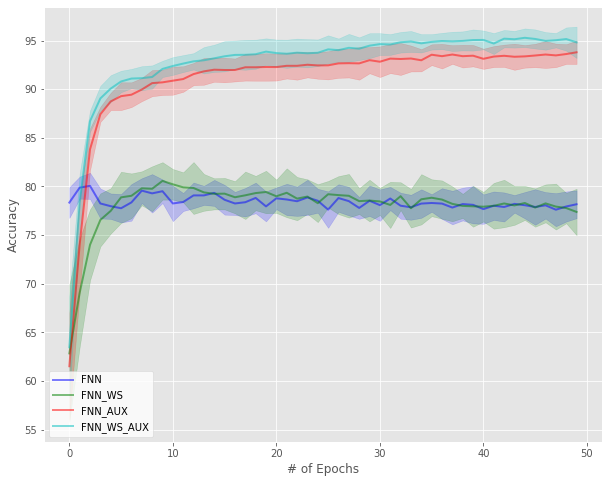

In [59]:
plotacc(histories_mean[:4], histories_std[:4], '#of epochs', 'loss', curve_names[:4])

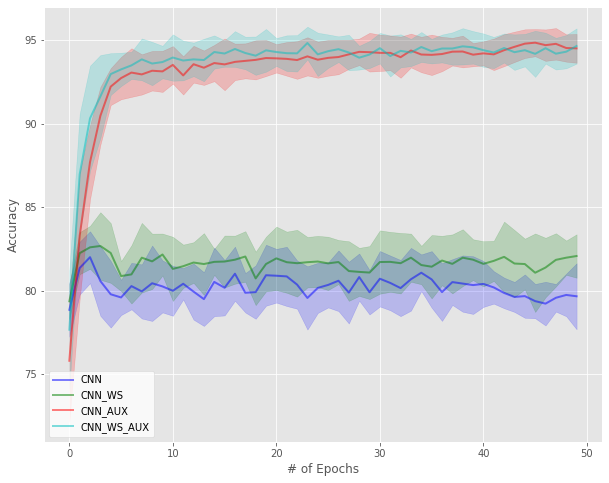

In [61]:
plotacc(histories_mean[4:8], histories_std[4:8], '#of epochs', 'loss', curve_names[4:8])

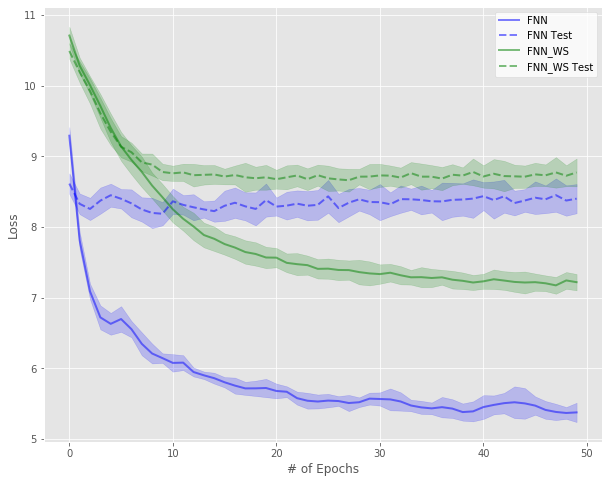

In [62]:
plotLoss(histories_mean[:2], histories_std[:2], '#of epochs', 'loss', curve_names[:2])

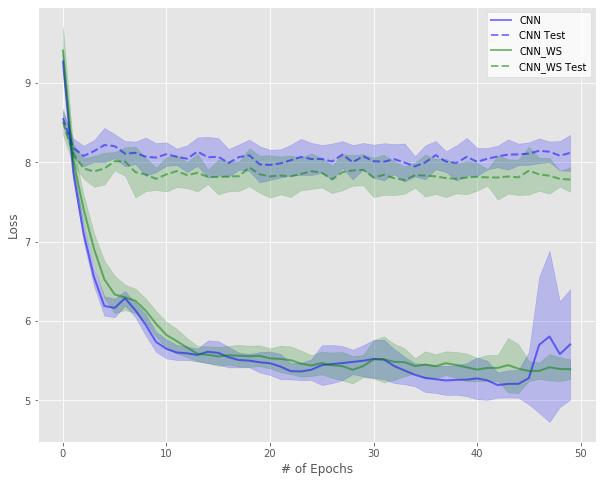

In [64]:
plotLoss(histories_mean[4:6], histories_std[4:6], '#of epochs', 'loss', curve_names[4:6])

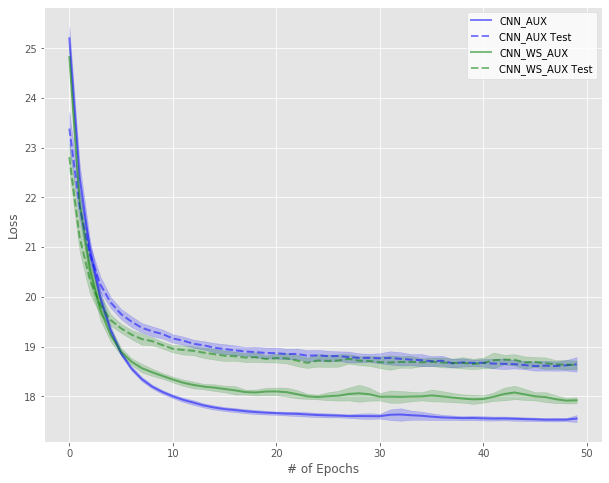

In [65]:
#plotLoss([histories[7]] + [histories[6]], '#of epochs', 'loss',  [curve_names[7]] + [curve_names[6]])
plotLoss(histories_mean[6:8], histories_std[6:8], '#of epochs', 'loss', curve_names[6:8])

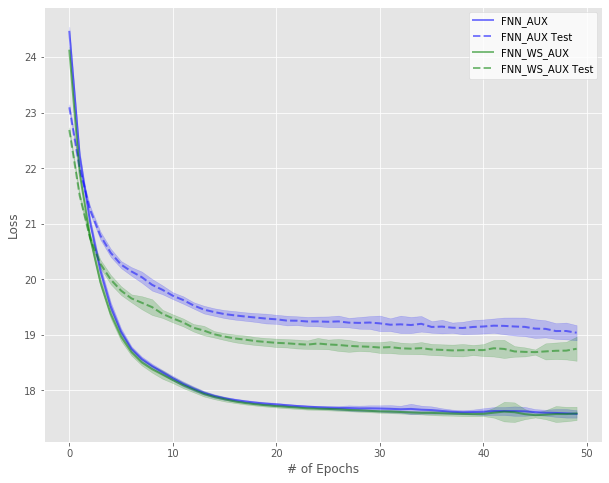

In [66]:
#plotLoss(histories[2:4], '#of epochs', 'loss', curve_names[2:4])
plotLoss(histories_mean[2:4], histories_std[2:4], '#of epochs', 'loss', curve_names[2:4])

In [ ]:
"""# Do 10 runs for each model while saving the histories of the models to plot them
n_training = 10

# Computing losses
histories = []
models_accuracies = []
curve_names = [x['model'].__class__.__name__ for x in initialize_models()]
for i in range(n_training):
    models = initialize_models()
    accuracies = []
    for m in range(len(models)):
        history = train(models[m], train_input1, train_input2, train_classes1,  train_classes2,train_target, \
                        test_input1, test_input2, test_classes1, test_classes2,  test_target)
        acc_target, acc_d1, acc_d2 = compute_nb_errors(models[m]['model'], test_input1, test_input2, test_classes1, test_classes2, test_target)
        #print("\nAccuracy on target = ",acc_target)
        #print("Accuracy on digit 1 = ",acc_d1)
        #print("Accuracy on digit 2 = ",acc_d2)
        accuracies.append(acc_target)
        histories.append(history)
    models_accuracies.append(accuracies)
        
# Computing the mean loss
histories_mean = []
for m in range(len(models)):
    history = histories[m]
    histories_mean.append(history)
# Compute the sum of the losses
for n in range(1,n_training): 
    for m in range(len(models)):
        history = histories[n*8+m]
        histories_mean[m]['train_loss_history'] = [x + y for x, y in \
                                                   zip(histories_mean[m]['train_loss_history'],history['train_loss_history'])]
        histories_mean[m]['test_loss_history'] = [x + y for x, y in \
                                                   zip(histories_mean[m]['test_loss_history'],history['test_loss_history'])]
# Compute the average
for m in range(len(models)):
    histories_mean[m]['train_loss_history'] = [x/10 for x in histories_mean[m]['train_loss_history']]
    histories_mean[m]['test_loss_history'] = [x/10 for x in histories_mean[m]['test_loss_history']]
        
# Printing the mean accuracies
models_accuracies = [list(tup) for tup in zip(*models_accuracies)]
for c in range(len(curve_names)) :
    print("\n", curve_names[c], "Mean Test Accuracies : %.2f" %(sum(models_accuracies[c])/len(models_accuracies[c])))
    
# Printing the mean loss to check the coherence with the accuracies
for c in range(len(curve_names)) :
    print("\n", curve_names[c], "Mean Test loss :", histories_mean[c]['train_loss_history'])        
"""